In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
from IPython.display import display
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import keras_tuner as kt

# Description of Problem and Data

We hope to develop a model that can classify an image as metastatic cancer or not with high accuracy. The data used for training and testing is a modification of the PatchCamelyon (PCam) benchmark dataset. The modifications made to the dataset include the removal of duplicate images. The train and test set of data is already split. The train set contains 220,025 images and is 6.32 GB. The test set contains 57,458 images and is 1.65 GB. Each image is 96x96px with 3 RGB layers. The files are stored as .tiff or Tag Image File Format. 

For each image, we must predict the probability that the center 32x32px contain at least one pixel of tumor tissue. Accuracy is measured by the area under the ROC curve.

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

In [2]:
# Determine data available
os.listdir('/kaggle/input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

220025 training images
57458 testing images
Size of images: (96, 96, 3)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


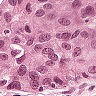

In [3]:
# Get training labels
train_labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
train_labels_df = pd.read_csv(train_labels_path)

# Get paths to data
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
train_path = '/kaggle/input/histopathologic-cancer-detection/train'

# Get summary of data size
print(f"{len(os.listdir(train_path))} training images")
print(f"{len(os.listdir(test_path))} testing images")

# Get summary of data dimension
val = os.listdir(train_path)[0]
img = Image.open(os.path.join(train_path, val))
print(f"Size of images: {np.array(img).shape}")

# Print start of labels to get an idea of format
print(train_labels_df.head())

# Get test ids
test_ids = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')['id']

# Example image
img

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

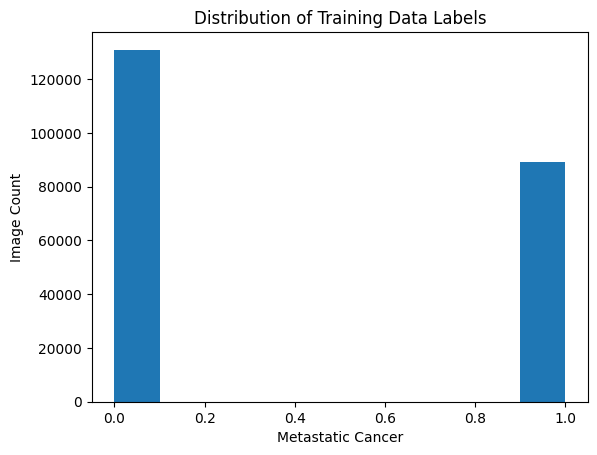

In [4]:
# Plot split of data labels in training set
plt.title("Distribution of Training Data Labels")
plt.hist(train_labels_df['label'])
plt.ylabel("Image Count")
plt.xlabel("Metastatic Cancer")
plt.show()
plt.close()

There are many more images with no cancer than there are with cancer. We may require data balancing or sub sampling the no cancer train set. Without balancing, our model could heavily favor predicting no cancer. 

Cancerous Samples


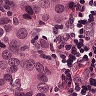

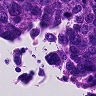

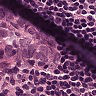

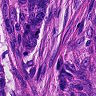

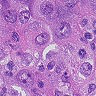

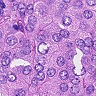

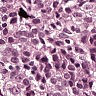

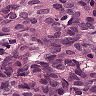

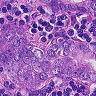

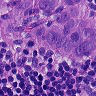

In [5]:
# Let's evaluate if we can see any differences between the cancerous and non cancerous cells
cancerous_ids = train_labels_df[train_labels_df['label'] == 1]['id']
noncancerous_ids = train_labels_df[train_labels_df['label'] == 0]['id']
# Select 10 random images from each
print("Cancerous Samples")
for i in random.sample(list(cancerous_ids), 10):
    im = Image.open(os.path.join(train_path, i + ".tif"))
    display(im)

Non Cancerous Samples


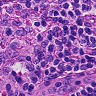

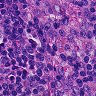

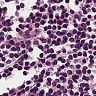

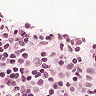

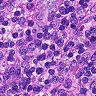

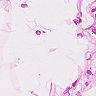

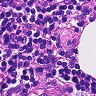

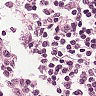

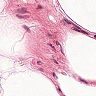

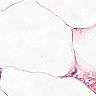

In [6]:
print("Non Cancerous Samples")
for i in random.sample(list(noncancerous_ids), 10):
    im = Image.open(os.path.join(train_path, i + ".tif"))
    display(im)

To my untrained eye, these images appear very similar.

Duplicates have already been removed from the data, but some cleaning is still required. We will creat a function that normalizes the pixel values before being input into the model. As we do not want to duplicate storage of the information in memory or on the device, we will normalize as images are read in for training. 

In [7]:
def normalize_image(img_array: np.array) -> np.array:
    # Set image values to floats
    img_array = img_array.astype('float32')
    # Divide by 255 to normalize between 0 and 1
    img_array /= 255.0
    # Return array
    return img_array

In addition to normalization, the edge of the image should be trimmed as to not make predictions based on pixels in the image except the center 32x32 pixels.

In [8]:
def grab_center_96_to_32(arr: np.array) -> np.array:
    return arr[32:64, 32:64, :]

Based on the EDA, I will use a CNN to evaluate the data. As the output is a probability that at least one pixel of data within the 32x32 pixel center of the image contains cancerous cells, the activation function of the output layer should produce a value between 0 and 1.

In [9]:
def load_images(path: str, batch_ids: list, labels_file: str = None) -> np.array:
    ID = 'id'
    LABEL = 'label'
    labels = None
    if labels_file:
        labels_dict = pd.read_csv(labels_file).set_index('id').to_dict()['label']
        labels = []
    images = []
    for image_id in batch_ids:
        if isinstance(labels, list):
            labels.append(labels_dict[image_id])
        img = cv2.imread(os.path.join(path, image_id + '.tif'))
        images.append(normalize_image(grab_center_96_to_32(img)))
    if labels:
        retval = np.array(images), np.expand_dims(np.array(labels), axis=1)
    else:
        retval = np.array(images)
    return retval

To balance the data labels as there are many more non cancerous samples than cancerous ones, we will do some down selection to get an equivalent set of training images. 

In [29]:
training_noncancerous_ids = random.sample(list(noncancerous_ids), 10000)
training_cancerous_ids = random.sample(list(cancerous_ids), 10000)

In [30]:
images, labels = load_images(train_path, training_noncancerous_ids + training_cancerous_ids, train_labels_path)

Let's look at the color ranges of these images:

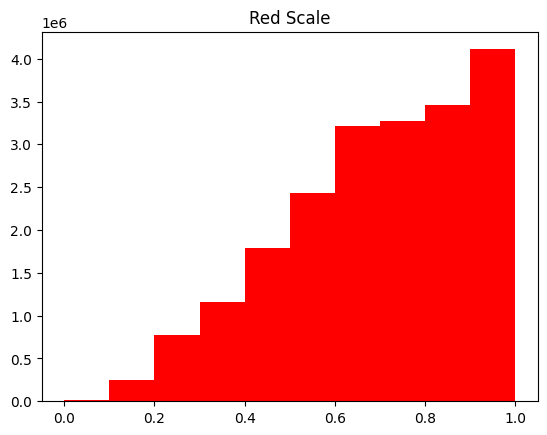

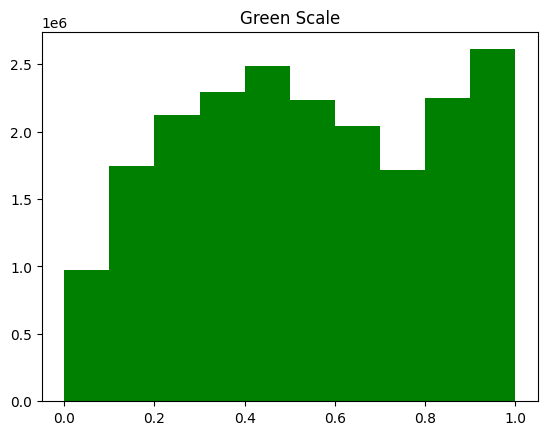

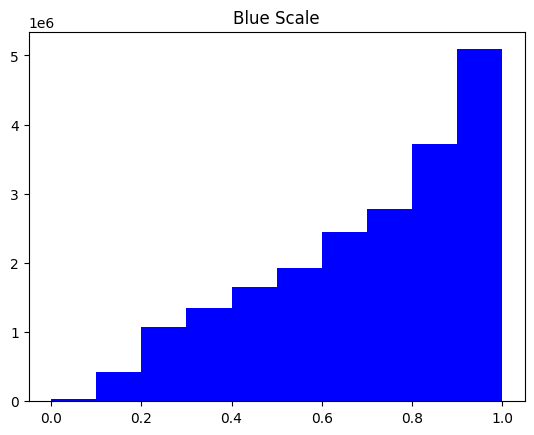

In [12]:
red = images[:,:,:,0].flatten()
green = images[:,:,:,1].flatten()
blue = images[:,:,:,2].flatten()

plt.hist(red, color = "red")
plt.title("Red Scale")
plt.show()
plt.close()

plt.hist(green, color="green")
plt.title("Green Scale")
plt.show()
plt.close()

plt.hist(blue, color="blue")
plt.title("Blue Scale")
plt.show()
plt.close()

Red and Blue features are closer to 255 for more images. While green is pretty uniformly distributed between 0 and 255. 

# Model Architecture

Model Architecture: 

Start with a simple CNN with 2 convolutional layers with ReLU activation and max pooling after the first layer. The last layer (output) will have a flatten and a sigmoid activation step to produce the probability. You should always start with the simplest model to see if the model can learn on the data. This is a very simple CNN model. This architecture is suitable for this problem because it has multiple convolutions that can look at smaller and larger areas of the images. The output layer activation function will outpu ta value between 0 and 1. 

Used this tutorial as a reference for the first architecture: https://www.tensorflow.org/tutorials/images/cnn.

In [31]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1)

### Model Setup

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 1)                 10817     
                                                                 
Total params: 30,209
Trainable params: 30,209
Non-trainable params: 0
____________________________________________________

### Compile Model

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['AUC'])

In [16]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

Epoch 1/10
563/563 [==============================] - 13s 22ms/step - loss: 0.5555 - auc: 0.7924 - val_loss: 0.5402 - val_auc: 0.8060
Epoch 2/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5283 - auc: 0.8151 - val_loss: 0.5502 - val_auc: 0.8075
Epoch 3/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5143 - auc: 0.8263 - val_loss: 0.5150 - val_auc: 0.8277
Epoch 4/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5062 - auc: 0.8329 - val_loss: 0.5245 - val_auc: 0.8204
Epoch 5/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4890 - auc: 0.8452 - val_loss: 0.5125 - val_auc: 0.8349
Epoch 6/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4805 - auc: 0.8517 - val_loss: 0.5625 - val_auc: 0.8340
Epoch 7/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4676 - auc: 0.8606 - val_loss: 0.5053 - val_auc: 0.8306
Epoch 8/10
563/563 [==============================] - 12s 21ms

<Axes: >

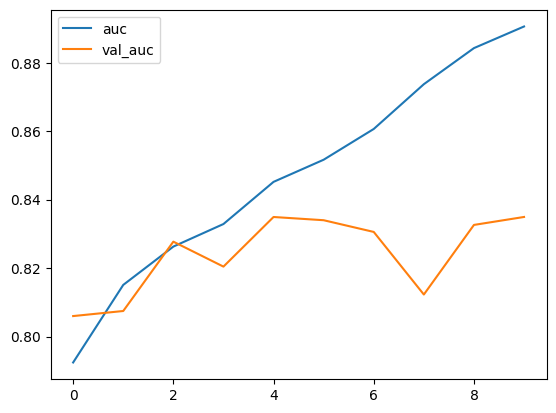

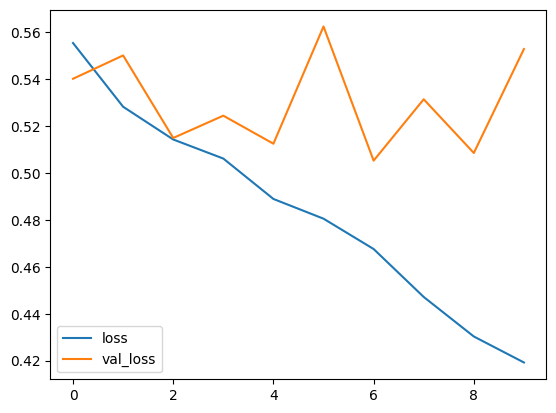

In [17]:
metrics = pd.DataFrame(history.history)
metrics[["auc","val_auc"]].plot()
metrics[["loss","val_loss"]].plot()

While training AUC is steadily increasing, the validation AUC stays stagnant. This is an early sign of overfitting. Let's see what adding an extra convolutional hidden layer and an extra dense layer with ReLU activation can help with.

In [18]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [19]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['AUC'])

In [20]:
history2 = model2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

Epoch 1/10
563/563 [==============================] - 14s 23ms/step - loss: 0.5857 - auc: 0.7588 - val_loss: 0.5512 - val_auc: 0.8076
Epoch 2/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5355 - auc: 0.8089 - val_loss: 0.5352 - val_auc: 0.8174
Epoch 3/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5241 - auc: 0.8183 - val_loss: 0.5223 - val_auc: 0.8209
Epoch 4/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5128 - auc: 0.8272 - val_loss: 0.5740 - val_auc: 0.7746
Epoch 5/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5010 - auc: 0.8360 - val_loss: 0.4994 - val_auc: 0.8365
Epoch 6/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4937 - auc: 0.8414 - val_loss: 0.5011 - val_auc: 0.8387
Epoch 7/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4853 - auc: 0.8476 - val_loss: 0.5225 - val_auc: 0.8334
Epoch 8/10
563/563 [==============================] - 12s 21ms

<Axes: >

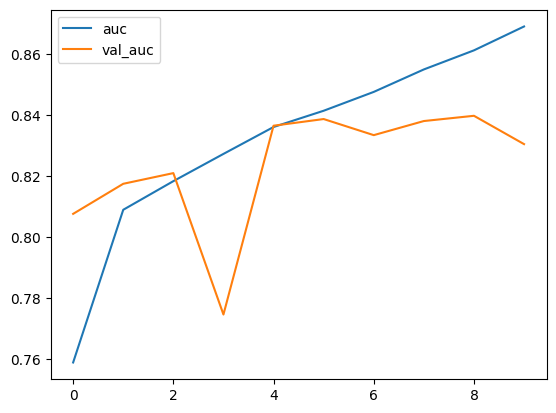

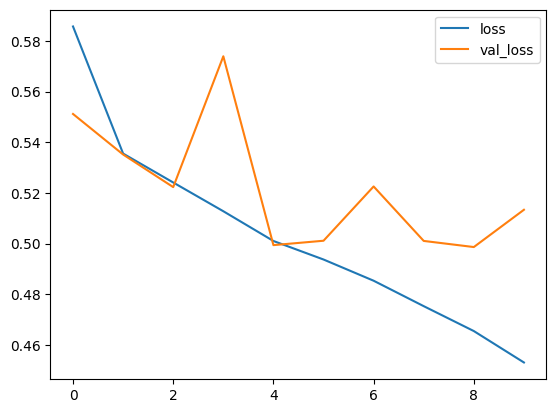

In [21]:
metrics = pd.DataFrame(history2.history)
metrics[["auc","val_auc"]].plot()
metrics[["loss","val_loss"]].plot()

The extra convolutional layer and dense layer improved accuracy, let's see if Batch Normalization improves stability.

In [22]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [23]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['AUC'])

In [24]:
history3 = model3.fit(train_images, train_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

Epoch 1/10
563/563 [==============================] - 13s 22ms/step - loss: 0.5437 - auc: 0.8041 - val_loss: 0.7137 - val_auc: 0.8168
Epoch 2/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5165 - auc: 0.8265 - val_loss: 0.7073 - val_auc: 0.8065
Epoch 3/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5053 - auc: 0.8347 - val_loss: 0.5915 - val_auc: 0.8299
Epoch 4/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4901 - auc: 0.8459 - val_loss: 0.5464 - val_auc: 0.8379
Epoch 5/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4865 - auc: 0.8485 - val_loss: 0.8069 - val_auc: 0.8297
Epoch 6/10
563/563 [==============================] - 11s 20ms/step - loss: 0.4781 - auc: 0.8540 - val_loss: 0.5280 - val_auc: 0.8338
Epoch 7/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4713 - auc: 0.8578 - val_loss: 0.5241 - val_auc: 0.8261
Epoch 8/10
563/563 [==============================] - 11s 20ms

<Axes: >

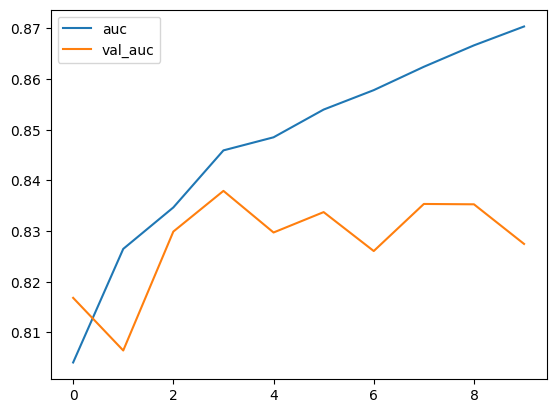

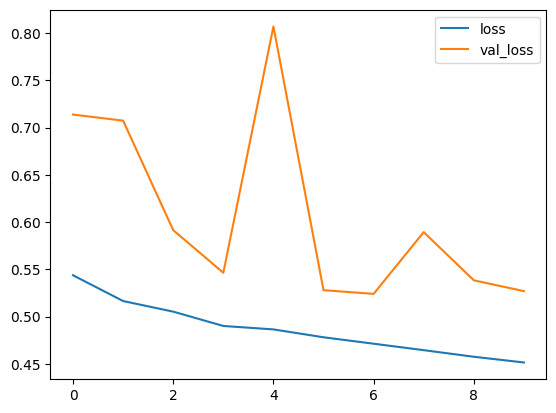

In [25]:
metrics = pd.DataFrame(history3.history)
metrics[["auc","val_auc"]].plot()
metrics[["loss","val_loss"]].plot()

Batch normalization did not improve stability of the model. The second model performed the best, so we will perform hyperparemeter tuning on this model. 

### Hyperparameter Tuning

In [32]:
# Perform a grid search for the best hyperparemeters
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
losses = [tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.BinaryFocalCrossentropy()]
best_val_auc = 0
best_lr = None
best_l = None
for lr in learning_rates:
    for l in losses:
        print(lr)
        print(l)
        model2 = models.Sequential()
        model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model2.add(layers.MaxPooling2D((2, 2)))
        model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model2.add(layers.MaxPooling2D((2, 2)))
        model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model2.add(layers.Flatten())
        model2.add(layers.Dense(100, activation="relu"))
        model2.add(layers.Dense(1, activation='sigmoid'))
        model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=l, metrics=['AUC'])
        history = model2.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))
        if history.history['val_auc'][-1] > best_val_auc:
            best_val_auc = history.history['val_auc'][-1]
            best_lr = lr
            best_l = l
print(f"Best Learning Rate: {best_lr}")
print(f"Best Loss: {best_l}")

0.01
Epoch 1/10
563/563 [==============================] - 68s 21ms/step - loss: 0.6944 - auc: 0.4958 - val_loss: 0.6933 - val_auc: 0.5000
Epoch 2/10
563/563 [==============================] - 12s 21ms/step - loss: 0.6932 - auc: 0.5070 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 3/10
563/563 [==============================] - 12s 21ms/step - loss: 0.6934 - auc: 0.4990 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 4/10
563/563 [==============================] - 12s 21ms/step - loss: 0.6934 - auc: 0.5010 - val_loss: 0.6933 - val_auc: 0.5000
Epoch 5/10
563/563 [==============================] - 12s 22ms/step - loss: 0.6933 - auc: 0.5033 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 6/10
563/563 [==============================] - 12s 21ms/step - loss: 0.6934 - auc: 0.4974 - val_loss: 0.6937 - val_auc: 0.5000
Epoch 7/10
563/563 [==============================] - 12s 22ms/step - loss: 0.6934 - auc: 0.4959 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 8/10
563/563 [==============================] - 12s

In [36]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr), loss=best_l, metrics=['AUC'])
best_history = model2.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 flatten_14 (Flatten)        (None, 1024)            

### Capture test results

In [37]:
import time
s = time.time()
test_images = load_images(test_path, test_ids)
print(f"{time.time() - s}")


100.89806032180786


In [38]:
test_pred = model2.predict(test_images)

1796/1796 [==============================] - 11s 6ms/step


In [40]:
pd.DataFrame({'id': test_ids, 'label': test_pred.flatten()}).to_csv("submission.csv", index=False)

# Results and Analysis

Best Model Results


<Axes: >

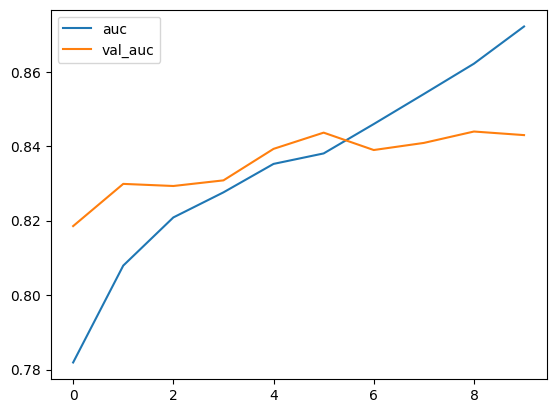

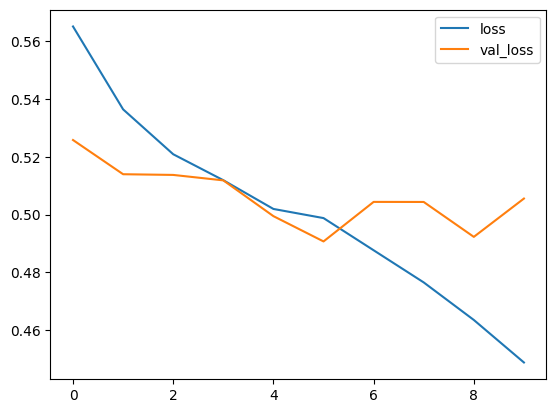

In [41]:
print("Best Model Results")
metrics = pd.DataFrame(best_history.history)
metrics[["auc","val_auc"]].plot()
metrics[["loss","val_loss"]].plot()

I ran a grid search hyperparameter tuning algorithm. I iterated through a list of learning rates and loss functions. Then I evaluated if the validation AUC had improved over past hyperparameter sets. This resulted in the best hyperparameters being a learning rate of 0.0005 and a Binary Crossentropy loss function. Results are shown below of hyperparameter tuning

| Loss   | Learning Rate             | Val AUC |

| 0.0001 | Binary Crossentropy       | 0.8391 |

| 0.0001 | Binary Focal Crossentropy | 0.8373 |

***| 0.0005 | Binary Crossentropy       | 0.8529 |***

| 0.0005 | Binary Focal Crossentropy | 0.8466 |

| 0.001  | Binary Crossentropy       | 0.8472 |

| 0.001  | Binary Focal Crossentropy | 0.8280 |

| 0.005  | Binary Crossentropy       | 0.8240 |

| 0.005  | Binary Focal Crossentropy | 0.8256 |

| 0.01   | Binary Crossentropy       | 0.50   |

| 0.01   | Binary Focal Crossentropy | 0.50   |

# Conclusion

## Learnings and Key Takeaways

During this project, I learned about CNN architecture and the value of additional layers. Some key takeaways would be that batch normalization does not always improve model performance and stability and that 10 epochs may not be enough to compare model accuracy. 

## What went wrong?

Batch normalization did not improve performance. 

Loading data took a very long time. 



## Improvements for the future

Possible improvements include trying a ResNet architecture. Since this is such a large dataset, it is possible that transfer learning may be applicable to this problem. Potentially using a model trained on ImageNet and applying it to this data would yield high accuracy results. 